# Solution for ZINDI Runmila TB competition





### In order to iterate quickly, I adapted the underlying structure from [Zach Mueller's extraordinarily useful github](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/03_Cross_Validation.ipynb) for working with the [fastai library](https://docs.fast.ai/). The best place to get started in deep learning and machine learning, in my opinion, is [fastai's course](https://course.fast.ai/).
 

William Miller (*BCAM, EHU/UPV, Anami Precision*) - November 18, 2020



### Install Requirements and Get Data

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fastai --upgrade
!pip install efficientnet-pytorch --upgrade

In [2]:
import fastai
print(fastai.__version__)
# should be 2.1.5

2.1.5


In [3]:
# To download the files from Johnowhitaker's Google Drive Share
# You must place a link in your "My Drive" or wherever you mount your Google Drive
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!cp /content/gdrive/My\ Drive/__Runmila\ TB/images_800px.zip /content/
!cp /content/gdrive/My\ Drive/__Runmila\ TB/images_fullsize.zip /content/
!cp /content/gdrive/My\ Drive/__Runmila\ TB/Test.csv /content/
!cp /content/gdrive/My\ Drive/__Runmila\ TB/Train.csv /content/
!cp /content/gdrive/My\ Drive/__Runmila\ TB/SampleSubmission.csv /content/

In [ ]:
!mkdir /content/input
!unzip /content/images_800px.zip -d /content/input/
!unzip /content/images_fullsize.zip -d /content/input/

## Import Libraries

In [6]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
import pandas as pd
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
from efficientnet_pytorch import EfficientNet
import gc
import cv2 as cv
import PIL

In [7]:
# Seed everything
seed = 2021
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.torch.manual_seed(seed)
torch.set_deterministic(True)
torch.backends.cudnn.deterministic = True

# Solution Explained

My solution uses fastai (2.1.5) for training and inference. I selected the [EfficientNet-B7 architecture](https://arxiv.org/abs/1905.11946) and used pre-trained [ImageNet weights](https://github.com/lukemelas/EfficientNet-PyTorch).

To determine adequate hyperparameters, I used a 80/20 Train/Test split. Using those parameters, I trained models on the entire train set, as in this notebook. The valid_loss and accuracy reported should not be considered in the output of the models using the full Train set. The validation data which is used to compute these metrics is also in the train set because I am using the complete data set for the final model.

My training consisted of 2 steps. First, using the small images (800px) and a crop size (input to model) of 512px. Then, a second stage using the full size images with a 1024px crop. 

Both models use the same weights from the first stage of training (using the 512px crop). Using the 512px images, I trained for 30 epochs and saved the weights. Then using the weights from this first stage, I did 2 variants for the 2nd stage:
1. I trained with full size images for 10 epochs and created a  submission
2. I trained with full size images for 5 epochs. I lowered the learning rate and trained for 5 more epochs. Then, I made my inference for submission.

Training was done in all stages using [One-Cycle Training](https://arxiv.org/pdf/1803.09820.pdf) with [Ranger](https://medium.com/@lessw/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d) optimizer and weight decay of 1e-3. The learning rates are indicated in the code below. Finally, I also used Mixed Precision Training.

Data Augmentation: I used RandomResizedCrop, Rotate, Contrast, Brightness. I also used [MixUp](https://arxiv.org/abs/1710.09412) augmentation. 

Finally, I did a simple 50/50 blend of the 2 submissions for my highest scoring submission.

Thank you for hosting an excellent competition!



## Start Code and Solution

In [8]:
def clean_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [9]:
def getLabel(fn):
    return train.to_numpy()[:,2][np.where((train.to_numpy()[:,1] == fn.name[:-4]))[0][0]]

In [10]:
path = Path('./input')
train_imgs = get_image_files(path/'strain')
tst_imgs = get_image_files(path/'stest')
train = pd.read_csv('./Train.csv')
train['LABEL'] = np.where(train['LABEL'] == 1, 'TB', 'Normal') 
test = pd.read_csv('./Test.csv')
len(train_imgs), len(tst_imgs), train.shape, test.shape

(718, 82, (718, 3), (82, 2))

In [11]:
train.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,TB
1,train/GVVXXDOZ.png,GVVXXDOZ,Normal
2,train/PMRSQLXN.png,PMRSQLXN,Normal
3,train/JXISWDUU.png,JXISWDUU,TB
4,train/JVWMAACC.png,JVWMAACC,TB


In [12]:
# Seed does not matter here, because I do final training with full data set 
# after selecting hyperparameters from 5 StratifiedKFolds

random.shuffle(train_imgs)

start_val = len(train_imgs) - int(len(train_imgs)*.05)
idxs = list(range(start_val, len(train_imgs)))

splits = IndexSplitter(idxs)

split = splits(train_imgs)
splits(train_imgs)

split_list = [split[0], split[1]]

split_list

split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))

In [13]:
### This is a little hacky. I create the Datasource, and get the labels.
### Then I add the validation set back to the test set and recreate it.
dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [getLabel, Categorize]],
                splits=split_list)

In [14]:
train_labels = L()
for i in range(len(dsrc.train)):
  train_labels.append(dsrc.train[i][1])
for i in range(len(dsrc.valid)):
  train_labels.append(dsrc.valid[i][1])
train_labels

(#718) [TensorCategory(0),TensorCategory(0),TensorCategory(0),TensorCategory(1),TensorCategory(1),TensorCategory(0),TensorCategory(0),TensorCategory(1),TensorCategory(0),TensorCategory(1)...]

In [15]:
### I add the validation set back to the train set.
split_list[0] += split_list[1]  

In [16]:
### Recreate the dataset with full train set
dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [getLabel, Categorize]],
                splits=split_list)

In [17]:
# Confirm that I have the full train and a few in valid so metrics and training 
# continue to work. It's a little hacky, but I was rushed. :)
dsrc.train, dsrc.valid 

((#718) [(PILImage mode=RGB size=795x800, TensorCategory(0)),(PILImage mode=RGB size=800x783, TensorCategory(0)),(PILImage mode=RGB size=731x800, TensorCategory(0)),(PILImage mode=RGB size=657x800, TensorCategory(1)),(PILImage mode=RGB size=800x787, TensorCategory(1)),(PILImage mode=RGB size=800x783, TensorCategory(0)),(PILImage mode=RGB size=657x800, TensorCategory(0)),(PILImage mode=RGB size=730x800, TensorCategory(1)),(PILImage mode=RGB size=756x800, TensorCategory(0)),(PILImage mode=RGB size=717x800, TensorCategory(1))...],
 (#35) [(PILImage mode=RGB size=766x800, TensorCategory(1)),(PILImage mode=RGB size=766x800, TensorCategory(0)),(PILImage mode=RGB size=755x800, TensorCategory(1)),(PILImage mode=RGB size=800x784, TensorCategory(0)),(PILImage mode=RGB size=800x787, TensorCategory(0)),(PILImage mode=RGB size=800x781, TensorCategory(1)),(PILImage mode=RGB size=800x786, TensorCategory(0)),(PILImage mode=RGB size=657x800, TensorCategory(0)),(PILImage mode=RGB size=657x800, TensorCat

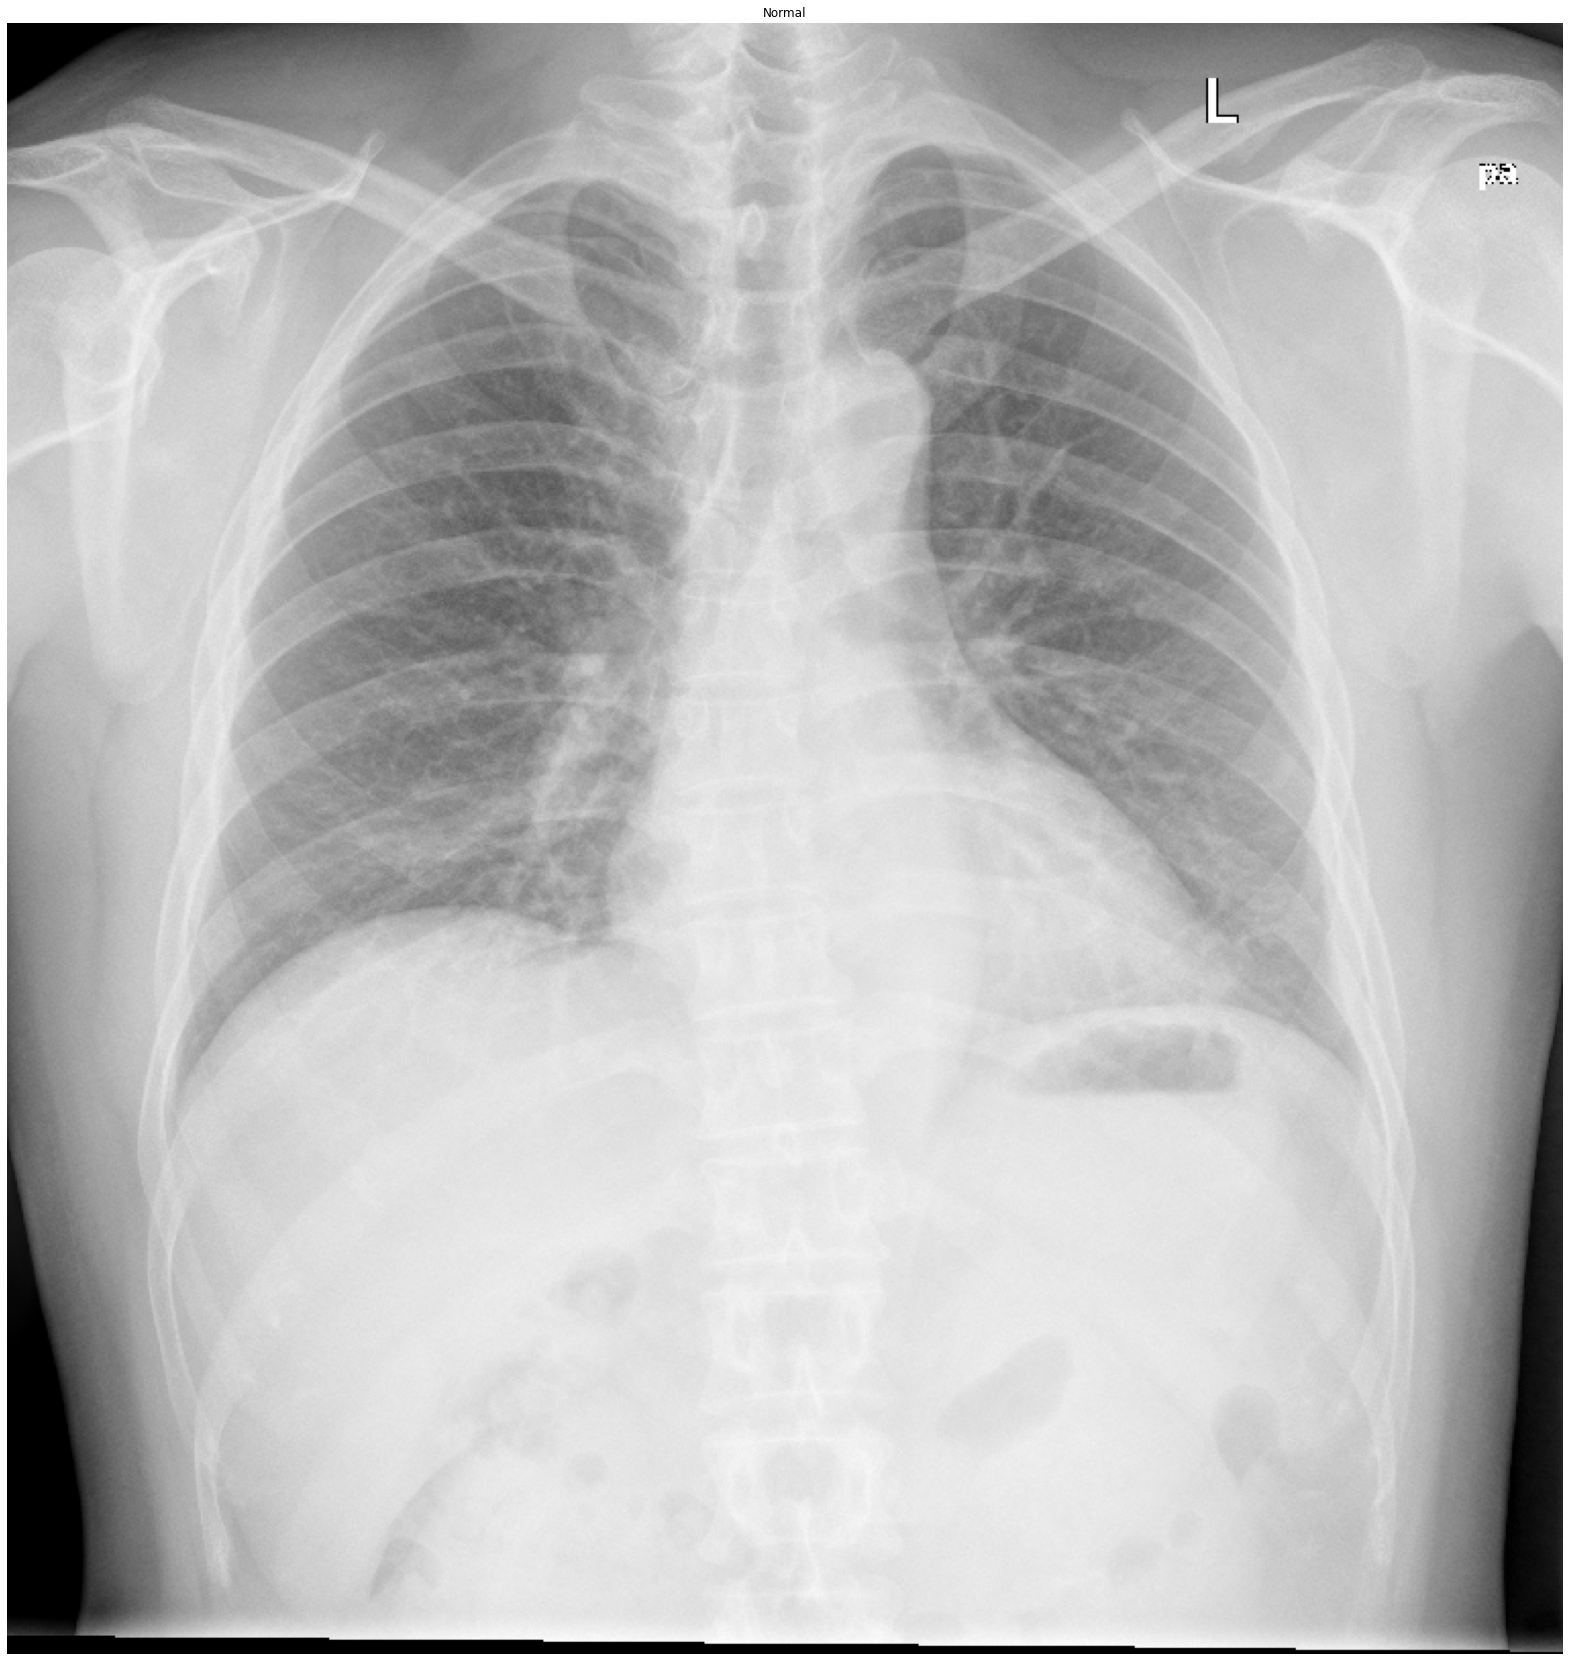

In [18]:
# Check image
show_at(dsrc.train, 200, figsize=(30,30))

In [19]:
SZ_CROP = 512
BS=8

item_tfms = [ToTensor(), RandomResizedCrop(SZ_CROP, min_scale=0.3, ratio=(.75, 1.33))]
batch_tfms = [IntToFloatTensor(),
              Rotate(max_deg=15),
              Contrast(max_lighting=.2), #.5
              Brightness(max_lighting=.2), 
              Normalize.from_stats(*imagenet_stats, cuda=True)
            ]

In [20]:
dls = dsrc.dataloaders(bs=BS, after_item=item_tfms, after_batch=batch_tfms)

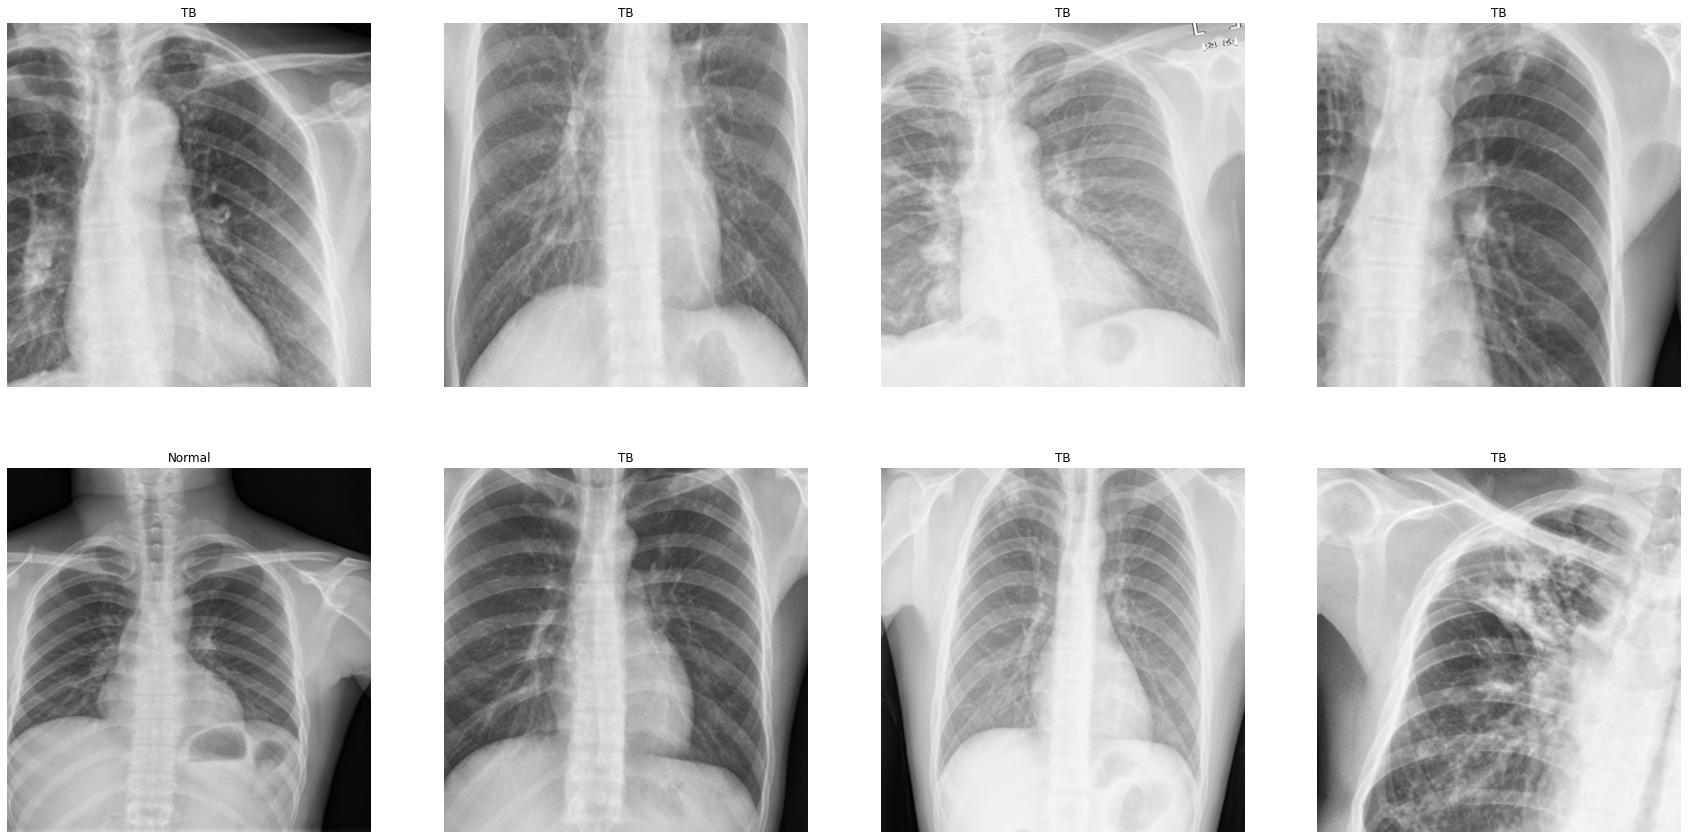

In [21]:
dls.show_batch(figsize=(30,15))

In [22]:
effnet_models = \
    {'efficientnet-b0': 1280, 'efficientnet-b1': 1280, 'efficientnet-b2': 1408, 'efficientnet-b3': 1536, 
     'efficientnet-b4': 1792, 'efficientnet-b5': 2048, 'efficientnet-b6': 2304, 'efficientnet-b7': 2560, 
     'efficientnet-b8': 2816, }

model_arch = 'efficientnet-b7'

In [23]:
model = EfficientNet.from_pretrained(model_arch, advprop=True) 
model._fc = nn.Linear(effnet_models[model_arch], dls.c) # the last layer... B6

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b7-4652b6dd.pth



Loaded pretrained weights for efficientnet-b7


In [24]:
rocBin = RocAucBinary() #RocAucBinary()
mixup = MixUp()
metric_list = [accuracy, rocBin]
opt_func = partial(ranger)

learn = None

learn = Learner(dls, model, opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
    metrics=metric_list, ).to_fp16()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.682972,0.679767,0.571429,0.687500,01:52
1,0.631540,0.543998,0.800000,0.901316,01:52
2,0.578703,0.623036,0.771429,0.891447,01:51
3,0.555297,0.277085,0.971429,1.000000,01:51
4,0.566330,0.321445,0.942857,0.993421,01:51
5,0.557647,0.250246,1.000000,1.000000,01:51
6,0.537591,0.467155,0.828571,0.986842,01:51
7,0.528134,0.306539,0.914286,1.000000,01:52
8,0.535273,0.241400,1.000000,1.000000,01:51
9,0.500369,0.216628,1.000000,1.000000,01:52


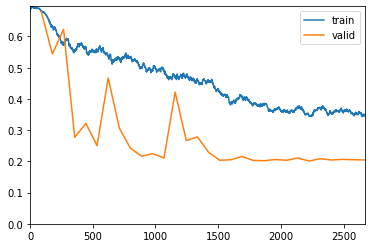

In [25]:
learn.fit_one_cycle(n_epoch=30, lr_max=6e-4, 
            wd=1e-3, cbs=[
                          # GradientAccumulation(n_acc=8),
                          ShowGraphCallback(), 
                          mixup,])

In [26]:
learn.save(f'effB7-model02-stage1-512-30ep-fulltrain-{seed}')

Path('models/effB7-model02-stage1-512-30ep-fulltrain-2021.pth')

## Model 1: Change to fullsize images and train 10 more epochs

In [27]:
train_imgs = [Path(fname.parent.name.replace('strain', './input/train'), fname.name) for fname in train_imgs]
tst_imgs = [Path(fname.parent.name.replace('stest', './input/test'), fname.name) for fname in tst_imgs]

In [28]:
dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [getLabel, Categorize]],
                splits=split_list)

In [29]:
dsrc.train, dsrc.valid 

((#718) [(PILImage mode=RGB size=2306x2320, TensorCategory(0)),(PILImage mode=RGB size=3000x2937, TensorCategory(0)),(PILImage mode=RGB size=2744x3000, TensorCategory(0)),(PILImage mode=RGB size=4020x4892, TensorCategory(1)),(PILImage mode=RGB size=2993x2943, TensorCategory(1)),(PILImage mode=RGB size=3000x2935, TensorCategory(0)),(PILImage mode=RGB size=4020x4892, TensorCategory(0)),(PILImage mode=RGB size=2128x2334, TensorCategory(1)),(PILImage mode=RGB size=2419x2562, TensorCategory(0)),(PILImage mode=RGB size=2676x2988, TensorCategory(1))...],
 (#35) [(PILImage mode=RGB size=2824x2951, TensorCategory(1)),(PILImage mode=RGB size=2282x2386, TensorCategory(0)),(PILImage mode=RGB size=2792x2959, TensorCategory(1)),(PILImage mode=RGB size=3000x2939, TensorCategory(0)),(PILImage mode=RGB size=3000x2951, TensorCategory(0)),(PILImage mode=RGB size=3000x2927, TensorCategory(1)),(PILImage mode=RGB size=2763x2713, TensorCategory(0)),(PILImage mode=RGB size=4020x4892, TensorCategory(0)),(PILIm

In [30]:
SZ_CROP = 1024
BS=2

item_tfms = [ToTensor(), RandomResizedCrop(SZ_CROP, min_scale=0.3, ratio=(.9, 1.1))]
batch_tfms = [IntToFloatTensor(),
              Rotate(max_deg=8),
              Contrast(max_lighting=.2), 
              Brightness(max_lighting=.2), 
              Normalize.from_stats(*imagenet_stats, cuda=True)
            ]

In [31]:
dls = dsrc.dataloaders(bs=BS, after_item=item_tfms, after_batch=batch_tfms)

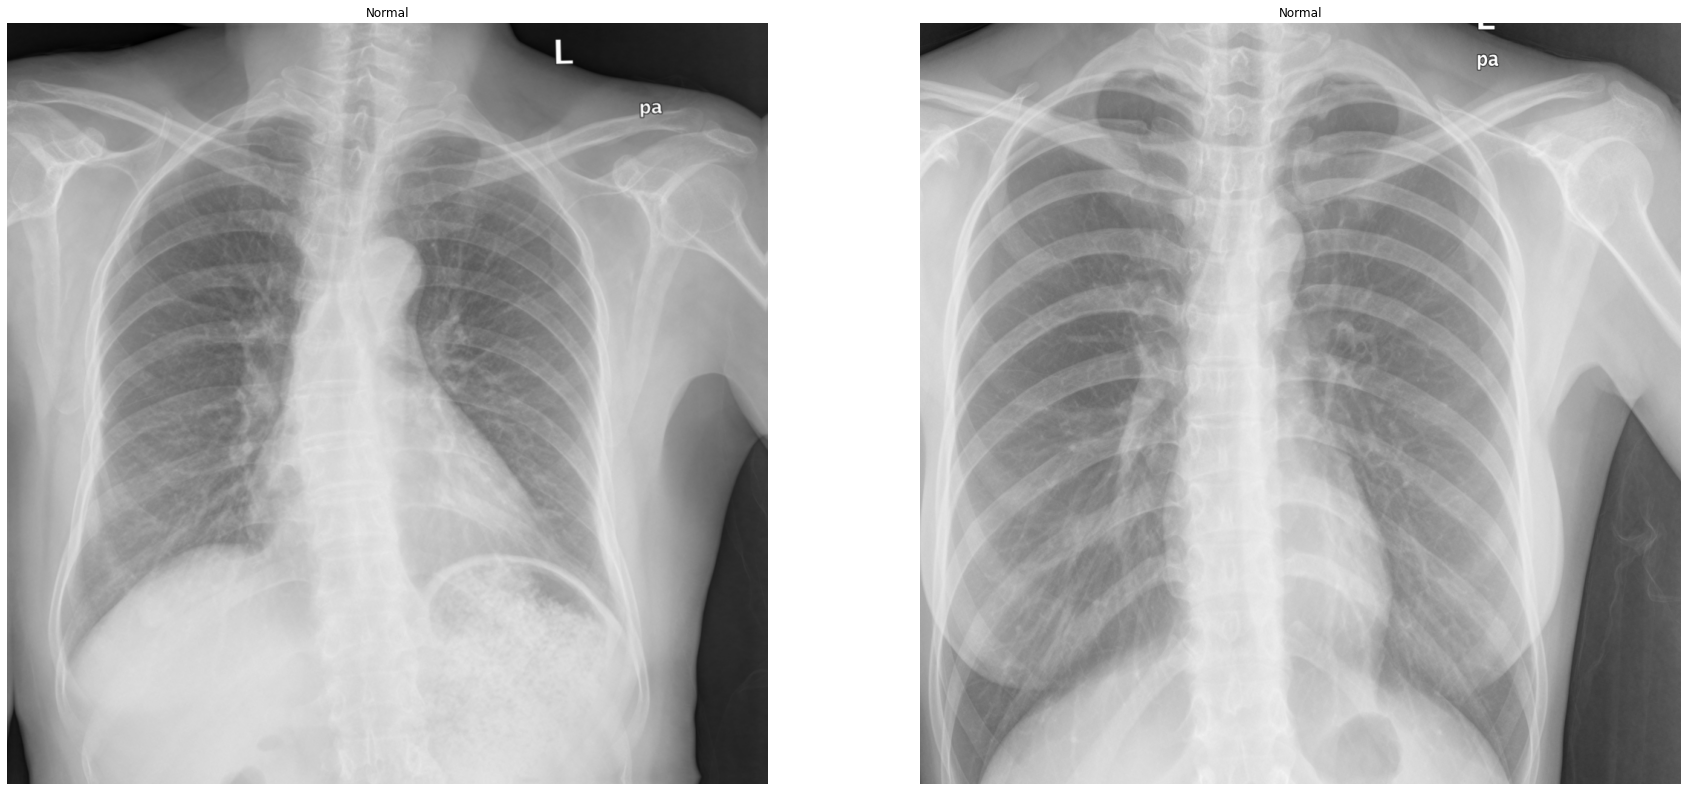

In [32]:
dls.show_batch(figsize=(30,30))

In [33]:
rocBin = RocAucBinary() #RocAucBinary()
mixup = MixUp()
metric_list = [accuracy, rocBin]
opt_func = partial(ranger)

learn = None

learn = Learner(dls, model, opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
    metrics=metric_list, ).to_fp16()

In [34]:
learn.load(f'effB7-model02-stage1-512-30ep-fulltrain-{seed}')

In [35]:
# Train with Gradient Accumulation; don't show Graph because train_loss is not calc'ed the same
learn.fit_one_cycle(n_epoch=10, lr_max=slice(2e-6, 1e-4), 
            wd=1e-3, cbs=[GradientAccumulation(n_acc=8),
                          mixup,])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,3644.985107,0.238010,0.971429,1.000000,07:01
1,1275.464600,0.212287,1.000000,1.000000,07:00
2,1150.804810,0.207367,1.000000,1.000000,07:00
3,1134.991699,0.206767,1.000000,1.000000,07:01
4,1038.607666,0.206995,1.000000,1.000000,07:00
5,2104.917725,0.209499,1.000000,1.000000,07:00
6,923.811707,0.210587,1.000000,1.000000,07:00
7,1040.959106,0.204208,1.000000,1.000000,07:01
8,909.631042,0.204566,1.000000,1.000000,07:00
9,961.934753,0.204708,1.000000,1.000000,07:00


In [36]:
learn.save(f'effB7-model01-stage2-1024-10ep-fulltrain-{seed}')

Path('models/effB7-model01-stage2-1024-10ep-fulltrain-2021.pth')

### Make Submission Model 1

In [37]:
BS = 8
test_dl = dls.test_dl(tst_imgs, bs=BS, device=torch.device('cuda'))

y, b = learn.get_preds(dl=test_dl)

In [38]:
fnames = [fname.name[:-4] for fname in tst_imgs]

In [39]:
df_sub = pd.DataFrame(list(zip(fnames, list(y.numpy()[:,1]))), columns=['ID','LABEL'])

In [40]:
sub = pd.read_csv('./SampleSubmission.csv')
sub = sub.merge(df_sub, on='ID').drop(columns='LABEL_x')
sub.rename(columns={'LABEL_y':'LABEL'}, inplace=True)
sub.head(20)

,ID,LABEL
0,GTWSHFYQ,0.075653
1,QTFSSMGD,0.049131
2,TBLBHSYT,0.939748
3,ZKETEOFG,0.908942
4,GKTPBGZP,0.149593
5,KHIMVBMD,0.957675
6,KUTPOASE,0.940079
7,NVCFDCZE,0.305594
8,CHDDLHBE,0.081009
9,HIJQIQJT,0.965771


In [41]:
sub.to_csv(f'./subB7-1024-ep10-fulltrain-{seed}.csv', index=False)

## Model 2: Change to fullsize images and train 5 more epochs

In [45]:
rocBin = RocAucBinary() #RocAucBinary()
mixup = MixUp()
metric_list = [accuracy, rocBin]
opt_func = partial(ranger)

learn = None

learn = Learner(dls, model, opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
    metrics=metric_list, ).to_fp16()

In [46]:
learn.load(f'effB7-model02-stage1-512-30ep-fulltrain-{seed}')

In [47]:
# Train with Gradient Accumulation; don't show Graph because train_loss is not calc'ed the same
learn.fit_one_cycle(n_epoch=5, lr_max=slice(2e-6, 1e-4), 
            wd=1e-3, cbs=[GradientAccumulation(n_acc=8),
                          mixup,])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,3397.923584,0.216258,1.000000,1.000000,06:58
1,2432.626709,0.218564,1.000000,1.000000,07:00
2,2087.669189,0.213450,1.000000,1.000000,07:00
3,2084.050781,0.204476,1.000000,1.000000,07:00
4,2208.109863,0.205162,1.000000,1.000000,07:00


In [48]:
## -02 is with RRC 0911 ratio
learn.save(f'effB7-model02-stage2-1024-5ep-fulltrain-02-{seed}')

Path('models/effB7-model02-stage2-1024-5ep-fulltrain-02-2021.pth')

In [49]:
learn.fit_one_cycle(n_epoch=5, lr_max=slice(2e-7, 1e-5), 
            wd=1e-3, cbs=[GradientAccumulation(n_acc=8),
                          mixup,])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,2096.788086,0.204547,1.000000,1.000000,06:59
1,2045.924194,0.204453,1.000000,1.000000,06:59
2,2024.983154,0.205023,1.000000,1.000000,06:59
3,2377.400879,0.204017,1.000000,1.000000,06:59
4,2065.494873,0.204709,1.000000,1.000000,06:58


In [50]:
learn.save(f'effB7-model02-stage3-1024-5ep-fulltrain-02-{seed}')

Path('models/effB7-model02-stage3-1024-5ep-fulltrain-02-2021.pth')

### Make Submission 2

In [51]:
BS = 8
test_dl = dls.test_dl(tst_imgs, bs=BS, device=torch.device('cuda'))

y, b = learn.get_preds(dl=test_dl)

In [52]:
fnames = [fname.name[:-4] for fname in tst_imgs]

In [53]:
df_sub = pd.DataFrame(list(zip(fnames, list(y.numpy()[:,1]))), columns=['ID','LABEL'])

In [54]:
sub = pd.read_csv('./SampleSubmission.csv')
sub = sub.merge(df_sub, on='ID').drop(columns='LABEL_x')
sub.rename(columns={'LABEL_y':'LABEL'}, inplace=True)
sub.head(20)

,ID,LABEL
0,GTWSHFYQ,0.070304
1,QTFSSMGD,0.042523
2,TBLBHSYT,0.948346
3,ZKETEOFG,0.895705
4,GKTPBGZP,0.202522
5,KHIMVBMD,0.962214
6,KUTPOASE,0.953837
7,NVCFDCZE,0.435316
8,CHDDLHBE,0.079282
9,HIJQIQJT,0.945751


In [55]:
sub.to_csv(f'./subB7-512ep30-then1024for5ep-then5more-02-{seed}.csv', index=False)

# Make Blend for final submission

In [56]:
sub1 = pd.read_csv(f'./subB7-1024-ep10-fulltrain-{seed}.csv')
sub2 = pd.read_csv(f'./subB7-512ep30-then1024for5ep-then5more-02-{seed}.csv')

In [57]:
sub1.head()

,ID,LABEL
0,GTWSHFYQ,0.075653
1,QTFSSMGD,0.049131
2,TBLBHSYT,0.939748
3,ZKETEOFG,0.908942
4,GKTPBGZP,0.149593


In [58]:
sub2.head()

,ID,LABEL
0,GTWSHFYQ,0.070304
1,QTFSSMGD,0.042523
2,TBLBHSYT,0.948346
3,ZKETEOFG,0.895705
4,GKTPBGZP,0.202522


In [59]:
sub_final = sub2.copy()

In [60]:
sub_final.loc[:,'LABEL'] = (sub1['LABEL'] + sub2['LABEL'])/2

In [61]:
sub_final.head(10)

,ID,LABEL
0,GTWSHFYQ,0.072978
1,QTFSSMGD,0.045827
2,TBLBHSYT,0.944047
3,ZKETEOFG,0.902324
4,GKTPBGZP,0.176058
5,KHIMVBMD,0.959945
6,KUTPOASE,0.946958
7,NVCFDCZE,0.370455
8,CHDDLHBE,0.080145
9,HIJQIQJT,0.955761


In [62]:
sub_final.to_csv(f'./sub_FINALBLEND-{seed}.csv', index=False)

# end

In [63]:
# !cp ./sub*.csv ./gdrive/MyDrive/__Runmila\ TB/submissions/

In [64]:
# !cp ./models/*.pth ./gdrive/MyDrive/__Runmila\ TB/models